# Sweep enrichments

Load global analysis variables:

In [3]:
%run standard.py

We look for enrichments in all the 90%-regions

In [4]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import scipy
import pandas
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
from collections import Counter, defaultdict
import random, bisect

random.seed(7)

import pyfaidx

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Plotting setup:

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore deprecation warnings from mainly seaborn:

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [7]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [8]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

Import variables global to the entire analysis:

In [9]:
import analysis_globals

## Convenience functions

In [10]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1, x
    return x[0]

## Load meta data

In [11]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')

In [12]:
def genes_close_to(genes, peaks, dist):    
    lst = list()
    for tup in peaks.itertuples():
        df = genes.copy().loc[(genes.start < tup.pos+dist) & (genes.end > tup.pos-dist)]
        df['peak_start'] = tup.start
        df['peak_end'] = tup.end
        lst.append(df)
    return pandas.concat(lst)

def genes_overlapping_intervals(genes, peaks):    
    lst = list()
    for tup in peaks.itertuples():
        df = genes.copy().loc[(genes.start < tup.end) & (genes.end > tup.start)]
        df['peak_start'] = tup.start
        df['peak_end'] = tup.end
        lst.append(df)
    return pandas.concat(lst)
        
def genes_in_intervals(genes, peaks):
    pos = genes.start + (genes.end-genes.start)/2
    idx = numpy.equal(numpy.searchsorted(peaks.start, pos) - 1, numpy.searchsorted(peaks.end, pos, side='left'))
    return genes.copy().iloc[idx]

## Sweep peak and region data

In [13]:
sweep_peaks = pandas.read_hdf(results_dir / f'sweep_peaks_{ech_calling_tag}.hdf')

In [14]:
extended_peak_regions_subset = (pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
                        )
extended_peak_regions_subset.head()
extended_peak_regions_subset['start'] = extended_peak_regions_subset.start_pos
extended_peak_regions_subset['end'] = extended_peak_regions_subset.end_pos

## Biomart gene annotation on chrX

In [15]:
biomart_genes_x = pandas.read_hdf(results_dir / 'biomart_genes.hdf').loc[lambda df: df.chrom == 'X']
print(len(biomart_genes_x))
biomart_genes_x.head()

2392


Gene stable ID chrom     start       end  strand       Gene type  \
3215  ENSG00000102309     X  71401203  71522776       1  protein_coding   
3325  ENSG00000186871     X  71424510  71458897      -1  protein_coding   
3382  ENSG00000198034     X  71475529  71497150      -1  protein_coding   
3594  ENSG00000102100     X  48760459  48769235      -1  protein_coding   
3815  ENSG00000102096     X  48770459  48776301      -1  protein_coding   

         name  
3215     PIN4  
3325   ERCC6L  
3382    RPS4X  
3594  SLC35A2  
3815     PIM2

## Testis genes from human protein atlas

2237 genes show elevated expression in the testis compared to other tissues:

In [16]:
hpatlas_testis_elevated = pandas.read_table(data_dir / 'tissue_specificity_rna_testis_elevated.tsv')
testis_elevated_genes = biomart_genes_x.loc[biomart_genes_x.name.isin(hpatlas_testis_elevated.Gene)]
len(testis_elevated_genes)

191

1079 enriched have at least five-fold higher mRNA levels compared to all other tissues

In [17]:
hpatlas_testis_enriched = pandas.read_table(data_dir / 'tissue_specificity_rna_testis_Tissue.tsv')
testis_enriched_genes = biomart_genes_x.loc[biomart_genes_x.name.isin(hpatlas_testis_enriched.Gene)]
len(testis_enriched_genes)

136

In [27]:
# overlap = genes_overlapping_intervals(testis_elevated_genes, extended_peak_regions_subset)
overlap = genes_close_to(testis_elevated_genes, extended_peak_regions_subset, 250000)
overlap

Gene stable ID chrom      start        end  strand       Gene type  \
28692  ENSG00000147081     X   49955406   49965664      -1  protein_coding   
29201  ENSG00000147082     X   49967364   50094909       1  protein_coding   
30740  ENSG00000122824     X   51075083   51080377       1  protein_coding   
30795  ENSG00000187690     X   51149767   51151687       1  protein_coding   
30809  ENSG00000196368     X   51232863   51239448      -1  protein_coding   
47112  ENSG00000196632     X   54219256   54385075      -1  protein_coding   
17743  ENSG00000204025     X  111125125  111147218       1       antisense   
58085  ENSG00000123496     X  114238538  114254540      -1  protein_coding   
40148  ENSG00000123165     X  127184943  127186382      -1  protein_coding   
48249  ENSG00000076770     X  131503345  131623996      -1  protein_coding   
44907  ENSG00000203870     X  154051623  154062937      -1  protein_coding   
45207  ENSG00000198082     X  154113317  154113833       1  protein_coding   

          name  peak_start   peak_end  
28692    AKAP4    49500000   50000000  
29201    CCNB3    49500000   50000000  
30740   NUDT10    50800000   51300000  
30795  CXorf67    50800000   51300000  
30809   NUDT11    50800000   51300000  
47112     WNK3    54000000   54400000  
17743  TRPC5OS   110200000  111100000  
58085  IL13RA2   114000000  114400000  
40148   ACTRT1   126800000  127400000  
48249    MBNL3   131200000  131600000  
44907    SMIM9   153900000  154500000  
45207   H2AFB1   153900000  154500000

Fisher's exact test show no enrichment:

In [17]:
overlap_all = genes_overlapping_intervals(biomart_genes_x, extended_peak_regions_subset)

nr_prot_overlapping = len(overlap_all.loc[lambda df: df['Gene type'] == 'protein_coding'])
nr_prot_biomart = len(biomart_genes_x.loc[lambda df: df['Gene type'] == 'protein_coding'])

table = [[len(overlap), len(testis_elevated_genes)-len(overlap)],
         [nr_prot_overlapping, nr_prot_biomart-nr_prot_overlapping]]
print(table)

#scipy.stats.fisher_exact([[20, 100],[100, 1000]], alternative='greater')
scipy.stats.fisher_exact(table, alternative='greater')

[[11, 180], [65, 765]]


(0.7192307692307692, 0.8742719557828054)

## All overlapping biomart genes

In [18]:
overlap_all['Gene type'].value_counts()

protein_coding       65
pseudogene           60
miRNA                17
lincRNA              10
snRNA                 9
misc_RNA              6
antisense             5
snoRNA                4
sense_intronic        3
sense_overlapping     1
rRNA                  1
Name: Gene type, dtype: int64

## All overlapping biomart *protein-coding* genes

In [19]:
df = (overlap_all
            #.loc[lambda df: df['Gene type'] == 'protein_coding']
            .loc[lambda df: (df['Gene type'] == 'protein_coding') & (df['Gene type'] != 'pseudogene')]
            .sort_values(['start'])
     )
df.to_hdf(results_dir / 'prot_genes_for_meritxell.hdf', 'df', format='table')
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

Gene stable ID chrom      start        end  strand       Gene type  \
35582  ENSG00000147010     X   19552093   19905719      -1  protein_coding   
36145  ENSG00000173681     X   19930978   19988416      -1  protein_coding   
36404  ENSG00000184368     X   20024831   20135035      -1  protein_coding   
37079  ENSG00000149970     X   21392536   21672813       1  protein_coding   
40854  ENSG00000165164     X   35937851   36008269       1  protein_coding   
40923  ENSG00000176034     X   36053908   36163187       1  protein_coding   
40954  ENSG00000205081     X   36246735   36403431       1  protein_coding   
41022  ENSG00000130962     X   37208528   37316548       1  protein_coding   
41058  ENSG00000250349     X   37208583   38546928       1  protein_coding   
41069  ENSG00000147036     X   37430822   37543716       1  protein_coding   
41082  ENSG00000047597     X   37545012   37591383       1  protein_coding   
41110  ENSG00000165168     X   37639264   37672714       1  protein_coding   
41205  ENSG00000165169     X   37696010   37706890      -1  protein_coding   
28083  ENSG00000101951     X   49593863   49598576       1  protein_coding   
28168  ENSG00000242013     X   49644470   49647166       1  protein_coding   
28225  ENSG00000171365     X   49687225   49863892       1  protein_coding   
28692  ENSG00000147081     X   49955406   49965664      -1  protein_coding   
29201  ENSG00000147082     X   49967364   50094909       1  protein_coding   
30740  ENSG00000122824     X   51075083   51080377       1  protein_coding   
30795  ENSG00000187690     X   51149767   51151687       1  protein_coding   
30809  ENSG00000196368     X   51232863   51239448      -1  protein_coding   
46202  ENSG00000172943     X   53963109   54075391      -1  protein_coding   
47023  ENSG00000184083     X   54094757   54209714      -1  protein_coding   
47112  ENSG00000196632     X   54219256   54385075      -1  protein_coding   
51119  ENSG00000102053     X   64708615   64727767       1  protein_coding   
51152  ENSG00000001497     X   64732462   64754655      -1  protein_coding   
51332  ENSG00000147065     X   64808257   64961791       1  protein_coding   
20647  ENSG00000131263     X   73805052   73834452      -1  protein_coding   
20865  ENSG00000050030     X   73952684   74145282      -1  protein_coding   
21280  ENSG00000131269     X   74273115   74376567      -1  protein_coding   
28304  ENSG00000196468     X   76709648   76712769       1  protein_coding   
28396  ENSG00000085224     X   76760356   77041702      -1  protein_coding   
30197  ENSG00000102158     X   77081861   77151090      -1  protein_coding   
31122  ENSG00000131174     X   77154935   77162870       1  protein_coding   
31175  ENSG00000165240     X   77166194   77305892       1  protein_coding   
31967  ENSG00000226784     X   77223458   77225135      -1  protein_coding   
57194  ENSG00000077264     X  110187513  110470589       1  protein_coding   
57331  ENSG00000077274     X  110488331  110513751      -1  protein_coding   
57369  ENSG00000077279     X  110537007  110655603      -1  protein_coding   
57571  ENSG00000101901     X  110909043  111003877       1  protein_coding   
57880  ENSG00000072315     X  111017543  111326004      -1  protein_coding   
58047  ENSG00000147246     X  113818551  114144624       1  protein_coding   
58085  ENSG00000123496     X  114238538  114254540      -1  protein_coding   
58185  ENSG00000130224     X  114345185  114468635      -1  protein_coding   
40148  ENSG00000123165     X  127184943  127186382      -1  protein_coding   
46899  ENSG00000165675     X  129757350  130037208      -1  protein_coding   
47030  ENSG00000147256     X  130192216  130223857       1  protein_coding   
47695  ENSG00000134602     X  131157293  131209971       1  protein_coding   
48016  ENSG00000165694     X  131211021  131262048      -1  protein_coding   
48059  ENSG00000123728     X  131337053  131353471      -1  protein_coding   
48249  ENSG00000076770     X  

## All overlapping biomart *non-coding* genes

In [20]:
df = (overlap_all
            #.loc[lambda df: df['Gene type'] == 'protein_coding']
            .loc[lambda df: (df['Gene type'] != 'protein_coding') & (df['Gene type'] != 'pseudogene')]
            .sort_values(['start']))
df.to_hdf(results_dir / 'noncoding_genes_for_meritxell.hdf', 'df', format='table')
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

Gene stable ID chrom      start        end  strand          Gene type  \
48163  ENSG00000206663     X   20003176   20003277      -1           misc_RNA   
48165  ENSG00000264566     X   20035206   20035305      -1              miRNA   
48173  ENSG00000206716     X   21232755   21232861       1              snRNA   
48180  ENSG00000266822     X   21581190   21581281       1              miRNA   
49075  ENSG00000206733     X   36040056   36040162      -1              snRNA   
49079  ENSG00000226484     X   36383741   36458375      -1          antisense   
6638   ENSG00000234390     X   49641327   49643844      -1            lincRNA   
6671   ENSG00000201341     X   49709947   49710053      -1              snRNA   
6951   ENSG00000207758     X   49767754   49767844       1              miRNA   
6958   ENSG00000207768     X   49768109   49768194       1              miRNA   
6969   ENSG00000265152     X   49771262   49771344       1              miRNA   
6979   ENSG00000207785     X   49773039   49773122       1              miRNA   
6992   ENSG00000208015     X   49773572   49773636       1              miRNA   
7006   ENSG00000211538     X   49774330   49774413       1              miRNA   
7014   ENSG00000239057     X   49775279   49775357       1              miRNA   
7023   ENSG00000207970     X   49777849   49777945       1              miRNA   
7031   ENSG00000272080     X   49779206   49779291       1              miRNA   
7056   ENSG00000202495     X   49935841   49935941      -1           misc_RNA   
10589  ENSG00000230317     X   50838690   50914232      -1            lincRNA   
10684  ENSG00000229151     X   51099796   51139314      -1          antisense   
10696  ENSG00000226530     X   51139363   51208513       1            lincRNA   
10714  ENSG00000234766     X   51244942   51253857      -1            lincRNA   
19921  ENSG00000252175     X   54091278   54091399      -1             snoRNA   
19952  ENSG00000207104     X   54369979   54370085       1              snRNA   
28529  ENSG00000270641     X   73012040   73049066       1            lincRNA   
28566  ENSG00000229807     X   73040486   73072588      -1            lincRNA   
29032  ENSG00000225470     X   73164159   73290243       1            lincRNA   
29160  ENSG00000228906     X   73168808   73169393       1            lincRNA   
29271  ENSG00000271199     X   73177894   73189320      -1  sense_overlapping   
29293  ENSG00000230590     X   73183790   73513409      -1            lincRNA   
29490  ENSG00000270223     X   73229224   73231303      -1     sense_intronic   
30052  ENSG00000271430     X   73420064   73461983      -1     sense_intronic   
30081  ENSG00000271533     X   73429811   73433495      -1     sense_intronic   
30087  ENSG00000202566     X   73438212   73438296      -1              miRNA   
30091  ENSG00000212027     X   73438382   73438453      -1              miRNA   
30107  ENSG00000265727     X   73462445   73462736      -1           misc_RNA   
30239  ENSG00000199885     X   73899888   73899994       1              snRNA   
30738  ENSG00000200906     X   77092786   77092892       1              snRNA   
30739  ENSG00000263410     X   77140874   77141127       1           misc_RNA   
6368   ENSG00000252430     X   98640193   98640274      -1              miRNA   
17399  ENSG00000251954     X  110664738  110664836      -1              snRNA   
17461  ENSG00000260802     X  110754890  110765627       1            lincRNA   
17562  ENSG00000266829     X  110859125  110859401       1           misc_RNA   
17706  ENSG00000201420     X  110913057  110913176      -1               rRNA   
17716  ENSG00000229487     X  110949877  110954329      -1          antisense   
20214  ENSG00000199001     X  114058017  114058127       1              miRNA   
20338  ENSG00000222122     X  114266990  114267096       1              snRNA   
20502  ENSG00000271907     X  114360879  114361007      -1             snoRNA   
20508  ENSG00000212241     X  114373593

## Overlapping Chalmel genes

In [21]:
# chalmel_genes = pandas.read_hdf(results_dir / 'chalmel_genes.hdf')

In [22]:
# df = chalmel_genes.loc[lambda df: (df.Pattern.isin(['9', '10', '11', '12', '13'])) & (df.chrom == 'X'), 
#                   ['name', 'chrom', 'start', 'end', 'Pattern', 'Expression in Testis']]

# genes_overlapping_intervals(df, extended_peak_regions_subset)

## Overlapping circRNA from Trine Line

In [23]:
trine_line_x_genes = pandas.read_hdf(results_dir / 'trine_line_x_genes.hdf')

genes_overlapping_intervals(trine_line_x_genes, extended_peak_regions_subset)

chr      start        end                    ccName ovlpRepExon  \
7200  chrX   19983161   19988416    chrX_19983161-19988416     CXorf23   
7212  chrX   49962215   49963355    chrX_49962215-49963355       AKAP4   
7216  chrX   54013510   54014377    chrX_54013510-54014377        PHF8   
7186  chrX  114357089  114364762  chrX_114357089-114364762       LRCH2   

     ovlpRepRange strand  size  sumReads  max  median      mean  sumExp  \
7200      CXorf23      -  5255         3    3     0.0  0.250000       1   
7212        AKAP4      -  1140         2    2     0.0  0.166667       1   
7216         PHF8      -   867         2    2     0.0  0.166667       1   
7186        LRCH2      -  7673         2    2     0.0  0.166667       1   

     Pattern Expression.in.Testis  peak_start   peak_end  
7200       -                    -    19600000   20100000  
7212      13                SEHET    49500000   50000000  
7216     NaN                  NaN    54000000   54400000  
7186     NaN                  NaN   114000000  114400000

## GO enrichment analysis on Gorilla web server

In [20]:
with open(str(results_dir / 'candidate_gene_list.txt'), 'w') as f:
#     for name in overlap_all.loc[lambda df: df['Gene type'] == 'protein_coding'].name:
    for name in overlap_all.loc[lambda df: (df['Gene type'] == 'protein_coding') & (df['Gene type'] != 'pseudogene')].name:
        print(name, file=f)
        
with open(str(results_dir / 'bacground_gene_list.txt'), 'w') as f:
    for name in biomart_genes_x.loc[lambda df: df['Gene type'] == 'protein_coding'].name:
        print(name, file=f)

## Overlap to ampliconic genes

In [25]:
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')

In [26]:
extended_peak_regions_subset.head()

pos  peak_start  peak_end  peak_prop_swept  start_pos   end_pos  \
0  19850000.0    19800000  19900000         0.828571   19600000  20100000   
1  21250000.0    21200000  21300000         0.814286   21100000  21600000   
2  36300000.0    36200000  36400000         0.664286   36000000  36400000   
3  37500000.0    37300000  37700000         0.507143   37200000  37700000   
4  49750000.0    49500000  50000000         0.528571   49500000  50000000   

   prop_swept                                       swept_indivs     start  \
0    0.771429  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...  19600000   
1    0.785714  ['B_Australian-4', 'B_Crete-2', 'B_French-3', ...  21100000   
2    0.635714  ['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-...  36000000   
3    0.500000  ['B_Crete-2', 'B_Dai-4', 'B_Han-3', 'B_Karitia...  37200000   
4    0.528571  ['B_Australian-4', 'B_French-3', 'B_Papuan-15'...  49500000   

        end  
0  20100000  
1  21600000  
2  36400000  
3  37700000  
4  50000000

In [27]:
@genominterv.bootstrap('hg19', samples=100000)
def jaccard_test(query, annot):
    return genominterv.jaccard(query, annot)

#jaccard_stat, p_value = jaccard_test(intervals, other_intervals)
    

jaccard_test(extended_peak_regions_subset.assign(chrom = 'chrX'), 
             ampliconic_regions.loc[lambda df: df.chrom == 'X'].assign(chrom='chrX'))

(0.0, 1.0)

Non-random distance to ampliconic reginos not overlapping: Are ampliconic regions not overlapping low pi regions closer the low pi regions than expected?

In [28]:
ampl_reg_not_overlapping = genominterv.interval_diff(ampliconic_regions.loc[lambda df: df.chrom == 'X'],
                                                          extended_peak_regions_subset.assign(chrom = 'X'))
genominterv.proximity_test(ampl_reg_not_overlapping, extended_peak_regions_subset.assign(chrom = 'X'))

TestResult(statistic=0.2243200000000002, pvalue=0.0241)

## Overlap to low ILS regions

In [29]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
human_orang_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_orang_low_ils_regions_chrX.hdf')

Human-chimp ILS:

In [30]:
jaccard_test(extended_peak_regions_subset.assign(chrom='chrX'), 
             human_chimp_low_ils_regions_chrX.assign(chrom='chrX'))

(0.13452914798206278, 0.00024)

Human-orang ILS:

In [31]:
jaccard_test(extended_peak_regions_subset.assign(chrom='chrX'), 
             human_orang_low_ils_regions_chrX.assign(chrom='chrX'))

(0.07368421052631578, 0.12661)

## Plot for paper

In [32]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')
non_afr_total_swept = pandas.read_hdf(results_dir / f'non_afr_total_swept_{ech_calling_tag}.hdf')

extended_regions = pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')

ust_ishim_sweep_inclusion_incl_upgma = pandas.read_hdf(results_dir / f'ust_ishim_sweep_inclusion_incl_upgma_{ech_calling_tag}_90%.hdf')

ust_ishim_sweep_data = pandas.read_hdf(clique_data_with_ust_ishim_file_name)
ust_ishim_ech = ust_ishim_sweep_data.loc[(ust_ishim_sweep_data.swept == True) & (ust_ishim_sweep_data.indiv_1 == 'Ust_Ishim'), ['start', 'end']]

In [33]:
ust_ishim_ech['ech_run'] = (ust_ishim_ech.start.astype(float) != ust_ishim_ech.end.shift()).cumsum()
#ust_ishim_ech.groupby('ech_run').apply(lambda df: pandas.DataFrame(dict(start=[df.start.min()], end=[df.end.max()])))
ust_ishim_ech_coords = ust_ishim_ech.groupby('ech_run').agg(start=("start", "min"), end=("end", "max")).reset_index()
ust_ishim_ech_coords

ech_run      start        end
0        1   20700000   21600000
1        2   35900000   36600000
2        3   98500000   99200000
3        4  109400000  110900000
4        5  113800000  114500000
5        6  126800000  127600000

In [34]:
non_afr_total_swept['start_mb'] = non_afr_total_swept.start / 1000000
non_afr_total_swept['end_mb'] = non_afr_total_swept.end / 1000000

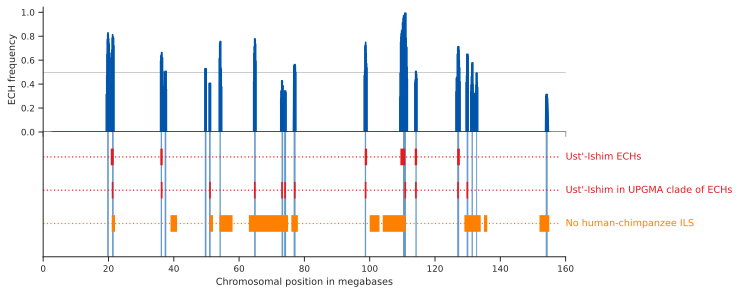

In [35]:
with sns.plotting_context('paper', font_scale=1):
    with sns.axes_style("ticks"):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=False)

        x = [j for i in zip(non_afr_total_swept.start/1000000, non_afr_total_swept.end/1000000) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax1.plot(x, y, color='#0055AA', zorder=1)        
        ax1.fill_between(x, 0, y, color='#0055AA', zorder=1)

#         ax1.scatter(sweep_peaks.loc[sweep_peaks.prop_swept>=0.5].pos, 
#                    sweep_peaks.loc[sweep_peaks.prop_swept>=0.5].prop_swept + 0.04,
#                    c='gray', marker='*', zorder=5)        
        
#         ax1.axhline(0.5, linestyle=(0, (1, 4)), color='grey', linewidth=1)
        ax1.axhline(0.5, color='black', linewidth=0.2, zorder=0)
    

        for tup in extended_regions.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos/1000000, 0), tup.end_pos/1000000-tup.start_pos/1000000, 1, 
                         facecolor='#0055AA',
                         linewidth=0,
                         alpha=0.6,
                         zorder=0))
        
        color = set1['red']
        ax2.plot([0, 158e6/1000000], [0.75, 0.75], color=color, linestyle=(0, (1, 2)))
        plt.text(1.6e8/1000000, 0.75, "Ust'-Ishim ECHs", horizontalalignment='left', verticalalignment='center', color=color)
        for tup in ust_ishim_ech_coords.itertuples():
            g = ax2.add_patch(Rectangle((tup.start/1000000, 0.7), tup.end/1000000-tup.start/1000000, 0.1, 
                         facecolor=color,
                         linewidth=0,
                         zorder=5))
                
        x = ust_ishim_sweep_inclusion_incl_upgma.loc[ust_ishim_sweep_inclusion_incl_upgma.tishkoff_included, 'peak_pos']/1000000
        y = [0.55] * len(x)
        ax2.plot([0, 158e6/1000000], [0.55, 0.55], color=color, linestyle=(0, (1, 2)))
        plt.text(1.6e8/1000000, 0.55, "Ust'-Ishim in UPGMA clade of ECHs", horizontalalignment='left', verticalalignment='center', color=color)        
        for x, y in zip(x, y):
            g = ax2.add_patch(Rectangle((x-250000/1000000, 0.5), 500000/1000000, 0.1, 
                         facecolor=color,
                         linewidth=0,
                         zorder=5))
            
        color = set1['orange']
        ax2.plot([0, 158e6/1000000], [0.35, 0.35], color=color, linestyle=(0, (1, 2)))
        plt.text(1.6e8/1000000, 0.35, "No human-chimpanzee ILS", horizontalalignment='left', verticalalignment='center', color=color)        
        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax2.add_patch(Rectangle((tup.start/1000000, 0.3), tup.end/1000000-tup.start/1000000, 0.1, 
                         facecolor=color,
                         linewidth=0,
                         alpha=1,
                         zorder=5))

#         color = '#000000'
#         ax2.plot([0, 158e6], [0.15, 0.15], color=color, linestyle=(0, (1, 2)))
#         plt.text(1.6e8, 0.15, "Ampliconic regions", horizontalalignment='left', verticalalignment='center', color=color)                
#         for tup in ampliconic_regions.itertuples():
#             g = ax2.add_patch(Rectangle((tup.start, 0.1), tup.end-tup.start, 0.1, 
#                          facecolor=color,
#                          linewidth=0,
#                          alpha=1,
#                          zorder=5))            

        plt.tight_layout()

        ax1.set_ylim(bottom=0)
        ax1.set_xlim(0,160)
        ax1.set_ylabel('ECH frequency')
        ax1.set_ylim(bottom=0)
        
#         ax2.set_ylim(0, 0.9)
        ax2.set_ylim(0.15, 0.9)
        ax2.get_yaxis().set_visible(False)
        ax2.set_xlabel('Chromosomal position in megabases')

        plt.subplots_adjust(hspace=0)

        sns.despine()
        
        plt.savefig(figures_dir / f'ech_peaks_with_annotation_{ech_calling_tag}.pdf', bbox_inches='tight')
        plt.savefig(figures_dir / f'ech_peaks_with_annotation_{ech_calling_tag}.png', bbox_inches='tight')


## Total swept with annotations

In [36]:
sweep_data = pandas.read_hdf(results_dir / f'sweep_data_{ech_calling_tag}.hdf')
missing_regions = pandas.read_hdf(results_dir / 'missing_regions.hdf')

plot_df = (sweep_data
           .groupby(['start', 'end', 'region_1', 'region_label_1'], observed=True)['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index(level=['start', 'end', 'region_1', 'region_label_1'])
          )

plot_df.sort_values(by=['start', 'region_1'], inplace=True)

plot_df['cum_nr_swept'] = (plot_df
                           .loc[plot_df.region_label_1 != 'Africa']
                           .groupby(['start', 'end'])['nr_swept']
                           .transform('cumsum')    
                           )
plot_df['cum_total'] = (plot_df
                        .loc[plot_df.region_label_1 != 'Africa']
                        .groupby(['start', 'end'])['total']
                        .transform('sum')    
                        )
plot_df.head(7)

start     end            region_1      region_label_1  nr_swept  total  \
0      0  100000              Africa              Africa         0     22   
1      0  100000         WestEurasia         WestEurasia         0     48   
2      0  100000           SouthAsia           SouthAsia         0     31   
3      0  100000  CentralAsiaSiberia  CentralAsiaSiberia         0     10   
4      0  100000             Oceania             Oceania         0     16   
5      0  100000            EastAsia            EastAsia         0     27   
6      0  100000             America             America         0      8   

   cum_nr_swept  cum_total  
0           NaN        NaN  
1           0.0      140.0  
2           0.0      140.0  
3           0.0      140.0  
4           0.0      140.0  
5           0.0      140.0  
6           0.0      140.0

Requires this fix to work:
    
    python -m pip install --user "git+https://github.com/javadba/mpld3@display_fix"
    

In [37]:
class ClickInfo(mpld3.plugins.PluginBase):
    """mpld3 Plugin for getting info on click        """

    JAVASCRIPT = """
    mpld3.register_plugin("clickinfo", ClickInfo);
    ClickInfo.prototype = Object.create(mpld3.Plugin.prototype);
    ClickInfo.prototype.constructor = ClickInfo;
    ClickInfo.prototype.requiredProps = ["id", "urls"];
    function ClickInfo(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    ClickInfo.prototype.draw = function(){
        var obj = mpld3.get_element(this.props.id);
        urls = this.props.urls;
        obj.elements().on("mousedown",
                          function(d, i){ 
                            window.open(urls[i], '_blank')});
    }
    """
    def __init__(self, points, urls):
        self.points = points
        self.urls = urls
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:            
            suffix = None
        self.dict_ = {"type": "clickinfo",
                      "id": mpld3.utils.get_id(points, suffix),
                      "urls": urls}

#ucsc_search = "https://genome-euro.ucsc.edu/cgi-bin/hgTracks?hgsid=226837763_FKVw0jsAcbutCxMf8luSHlzwx2xW&org=Human&db=hg37&position={}&pix=1361"
ucsc_search = "https://genome-euro.ucsc.edu/cgi-bin/hgTracks?db=hg19&pix=2000&position={}&hgsid=230604418_7ASTqKyqNTW8yadJActGtpWwO1V2"
    
# fig, ax = plt.subplots()
# points = ax.scatter(numpy.random.rand(50), numpy.random.rand(50),
#                     s=500, alpha=0.3)
# urls = [ucsc_search.format('CCR5') for i in range(50)]

# # mpld3.plugins.connect(fig, ClickInfo(points, urls))
# # mpld3.display(fig)

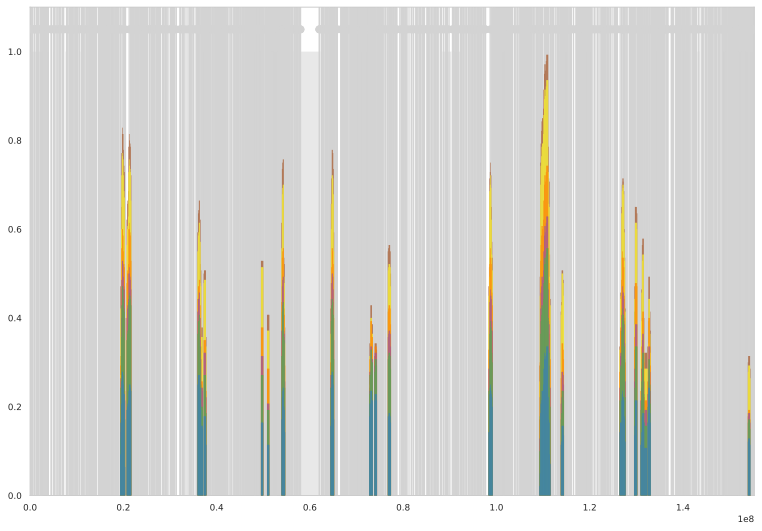

In [38]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
#     fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(13, 9),                         
#                                    subplot_kw={'xlim':(0, chromosome_lengths['X']), 'ylim':(0, 1)})

    fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(13, 9),                         
                                   subplot_kw={'xlim':(0, chromosome_lengths['X']), 'ylim':(0, 1.1)})


    zorder = 1

    zorder += 1
    genes = biomart_genes_x
    pos_list = list()
    labels = list()
    for tup in genes.itertuples():
        x = tup.start + (tup.end - tup.start) / 2
        pos_list.append(x)
        labels.append("{}".format(tup.name))
        ax1.add_line(Line2D([x, x], [0, 1.1], color='lightgrey', zorder=zorder))
    zorder += 1        
    scatter = ax1.scatter(pos_list, [1.05 for x in pos_list], c='lightgrey', s=50, zorder=zorder)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

    urls = [ucsc_search.format(tup.name) for tup in genes.itertuples()]
    mpld3.plugins.connect(fig, ClickInfo(scatter, urls))


#     zorder += 1        
#     genes = chalmel_genes_subset
#     pos_list = list()
#     labels = list()
#     for tup in genes.itertuples():
#         x = tup.start + (tup.end - tup.start) / 2
#         pos_list.append(x)
#         labels.append("{} {}".format(tup.name, tup.Pattern))
#         ax1.add_line(Line2D([x, x], [0, 1.1], color='red', zorder=zorder))
#     zorder += 1        
#     scatter = ax1.scatter(pos_list, [1.05 for x in pos_list], c='red', s=50, zorder=zorder)
#     tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
#     mpld3.plugins.connect(fig, tooltip)
    
#     urls = [ucsc_search.format(tup.name) for tup in genes.itertuples()]
#     mpld3.plugins.connect(fig, ClickInfo(scatter, urls))

    
#     zorder += 1        
#     genes = trine_line_x_genes
#     pos_list = list()
#     labels = list()
#     for tup in genes.itertuples():
#         x = tup.start + (tup.end - tup.start) / 2
#         pos_list.append(x)
#         labels.append("{}".format(tup.ovlpRepExon))
#         ax1.add_line(Line2D([x, x], [0, 1.1], color='pink', zorder=zorder))
#     zorder += 1        
#     scatter = ax1.scatter(pos_list, [1.05 for x in pos_list], c='pink', s=50, zorder=zorder)
#     tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
#     mpld3.plugins.connect(fig, tooltip)
    
#     urls = [ucsc_search.format(tup.ovlpRepExon) for tup in genes.itertuples()]
#     mpld3.plugins.connect(fig, ClickInfo(scatter, urls))

    
    regs = [x for x in plot_df.region_1.cat.categories if x != 'Africa'][::-1]
    for reg in regs:
        df = plot_df.loc[plot_df.region_label_1 == reg]
        zorder += 1        
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.cum_nr_swept/tup.cum_total, 
                                  facecolor=region_colors[reg], 
                                  linewidth=0,
                                  edgecolor=None,#region_colors[reg], 
                                  zorder=zorder))

#     df = plot_df.loc[plot_df.region_label_1 == 'Africa']
#     for tup in df.itertuples():
#         if tup.nr_swept:
#             g = ax2.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.nr_swept/tup.total, 
#                               facecolor=region_colors['Africa'], 
#                               edgecolor=None,#region_colors[reg], 
#                               ))

    zorder += 1        
    for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
        g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                 facecolor='lightgray', 
                 #edgecolor=None,
                  linewidth=0,
                 alpha=0.5,
                 zorder=zorder))
#         g = ax2.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
#                  facecolor='lightgray', 
#                  edgecolor=None,
#                  alpha=0.5,
#                  zorder=zorder))

  
    plt.savefig(str(figures_dir / "tmp2.pdf"))
    #plt.close() # closing teh plot suppres automatic plotting without plt.show()

#mpld3.display(fig)

## Get descriptions of relevant genes

In [39]:
%env http_proxy=http://proxyserv:3128
%env https_proxy=http://proxyserv:3128
        
from geneinfo import geneinfo, geneplot, geneplot
from geneinfo import ensembl_get_genes_region as get_genes

env: http_proxy=http://proxyserv:3128
env: https_proxy=http://proxyserv:3128


In [40]:
non_afr_total_swept = pandas.read_hdf(results_dir / f'non_afr_total_swept_{ech_calling_tag}.hdf') 
non_afr_total_swept.head()

index    start      end  is_non_african  nr_swept  total        pos  \
0      1  2700000  2800000            True         0    139  2750000.0   
1      3  2800000  2900000            True         0    140  2850000.0   
2      5  2900000  3000000            True         0    140  2950000.0   
3      7  3000000  3100000            True         0    140  3050000.0   
4      9  3100000  3200000            True         0    140  3150000.0   

   prop_swept  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [41]:
def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

plot_df = stairs(non_afr_total_swept)

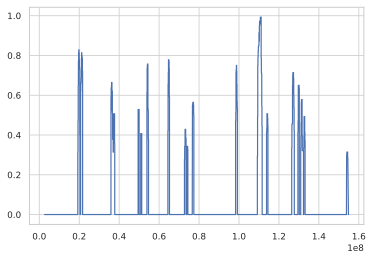

In [42]:
plt.plot(plot_df.pos, plot_df.prop_swept) ;

In [43]:
extended_peak_regions_subset

pos  peak_start   peak_end  peak_prop_swept  start_pos    end_pos  \
0    19850000.0    19800000   19900000         0.828571   19600000   20100000   
1    21250000.0    21200000   21300000         0.814286   21100000   21600000   
2    36300000.0    36200000   36400000         0.664286   36000000   36400000   
3    37500000.0    37300000   37700000         0.507143   37200000   37700000   
4    49750000.0    49500000   50000000         0.528571   49500000   50000000   
5    51100000.0    50800000   51400000         0.339286   50800000   51300000   
6    54300000.0    54200000   54400000         0.757143   54000000   54400000   
7    64800000.0    64700000   64900000         0.778571   64600000   65100000   
8    73150000.0    73000000   73300000         0.428571   73000000   73500000   
9    74100000.0    73900000   74300000         0.342857   73800000   74400000   
10   77050000.0    76900000   77200000         0.564286   76700000   77300000   
11   98750000.0    98700000   98800000         0.750000   98500000   98900000   
12  110900000.0   110700000  111100000         0.992857  110200000  111100000   
13  114150000.0   114000000  114300000         0.507143  114000000  114400000   
14  127050000.0   127000000  127100000         0.714286  126800000  127400000   
15  129900000.0   129700000  130100000         0.650000  129700000  130200000   
16  131450000.0   131300000  131600000         0.578571  131200000  131600000   
17  132750000.0   132600000  132900000         0.492857  132600000  132900000   
18  154200000.0   154000000  154400000         0.314286  153900000  154500000   

    prop_swept                                       swept_indivs      start  \
0     0.771429  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...   19600000   
1     0.785714  ['B_Australian-4', 'B_Crete-2', 'B_French-3', ...   21100000   
2     0.635714  ['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-...   36000000   
3     0.500000  ['B_Crete-2', 'B_Dai-4', 'B_Han-3', 'B_Karitia...   37200000   
4     0.528571  ['B_Australian-4', 'B_French-3', 'B_Papuan-15'...   49500000   
5     0.407143  ['B_Australian-4', 'B_Crete-2', 'B_Papuan-15',...   50800000   
6     0.735714  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...   54000000   
7     0.714286  ['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-...   64600000   
8     0.385714  ['B_French-3', 'B_Papuan-15', 'B_Sardinian-3',...   73000000   
9     0.314286  ['B_Crete-2', 'B_French-3', 'B_Sardinian-3', '...   73800000   
10    0.550000  ['B_Australian-4', 'B_French-3', 'B_Sardinian-...   76700000   
11    0.714286  ['B_Dai-4', 'B_French-3', 'B_Han-3', 'B_Kariti...   98500000   
12    0.950000  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...  110200000   
13    0.485714  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...  114000000   
14    0.650000  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...  126800000   
15    0.635714  ['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_...  129700000   
16    0.564286  ['B_Crete-2', 'B_French-3', 'B_Han-3', 'S_Abkh...  131200000   
17    0.492857  ['B_Australian-4', 'B_Crete-2', 'B_French-3', ...  132600000   
18    0.285714  ['B_Karitiana-3', 'S_Ami-2', 'S_Armenian-1', '...  153900000   

          end  
0    20100000  
1    21600000  
2    36400000  
3    37700000  
4    50000000  
5    51300000  
6    54400000  
7    65100000  
8    73500000  
9    74400000  
10   77300000  
11   98900000  
12  111100000  
13  114400000  
14  127400000  
15  130200000  
16  131600000  
17  132900000  
18  154500000

Read Meritxell's list of top differentially expressed genes:

In [44]:
diff_exp_genes = pd.read_csv('../data/DEG_XY_spermatids_filtered_pval1_fc2.tsv', sep='\t', header=None)[0].to_list()
'ACTRT1' in diff_exp_genes

True

Produce a list of genes overlapping peaks:

In [ ]:
records = []
for tup in list(extended_peak_regions_subset.itertuples()):
    for gene in get_genes('chrX', int(tup.pos)-500000, int(tup.pos)+500000, hg19=True):
        records.append((gene[0], 'chrX', gene[1], gene[2]))
candidate_genes = pd.DataFrame().from_records(records, columns=['name', 'chrom', 'start', 'end'])    
candidate_genes.to_hdf(results_dir / 'candidate_genes.hdf', 'df', format='table')
candidate_genes.name

In [46]:
candidate_genes.loc[(candidate_genes.start > 126000000) & (candidate_genes.end < 128000000)]

name chrom      start        end
250  CTD-2076M15.1  chrX  126794612  126796511
251    RP1-107N3.1  chrX  126862715  126864839
252    RP1-107N3.2  chrX  126930105  126930714
253    RP1-203C2.2  chrX  127232011  127232508
254    RP1-203C2.3  chrX  127256712  127257474
255    RP1-203C2.4  chrX  127261068  127262190
256       RPL7AP72  chrX  127447259  127448026
257    RP1-30E17.2  chrX  127457598  127734446
258         ACTRT1  chrX  127184943  127186382

In [47]:
'ACTRT1' in list(candidate_genes.name)

True

In [48]:
[x for x in candidate_genes.name if x in diff_exp_genes]

['DYNLT3',
 'SYTL5',
 'AKAP4',
 'GSPT2',
 'PHF8',
 'LAS1L',
 'VSIG4',
 'ZCCHC13',
 'RLIM',
 'ATRX',
 'ALG13',
 'HTR2C',
 'IL13RA2',
 'LRCH2',
 'ACTRT1',
 'SLC25A14',
 'TFDP3']

In [49]:
region_tups = list(extended_peak_regions_subset.itertuples())

def plot_next(i):
    tup = region_tups[i]
    ax = geneplot('chrX', tup.start-500000, tup.end+500000, hg19=True, figsize=(10, 4), highlight=diff_exp_genes, only_protein_coding=True)
    ax.plot(plot_df.pos, plot_df.prop_swept)
    ax.fill_between(plot_df.pos, plot_df.prop_swept, alpha=0.2)
    ax.set_xlim(tup.start-500000, tup.end+500000)
    ax.set_ylim(0, 1)
    ax.set_title(f'{tup.start}-{tup.end}')
    sns.despine(ax=ax)
    plt.tight_layout()

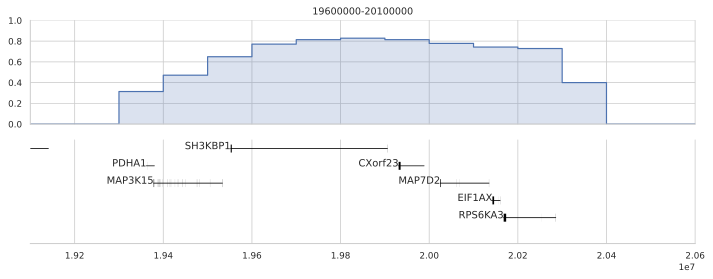

In [50]:
plot_next(0)

In [51]:
geneinfo('BCLAF3')
geneinfo('SH3KBP1')
geneinfo('MAP7D2')
geneinfo('EIF1AX')
geneinfo('EIF1AX-AS1')

**Symbol:** **_BCLAF3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CXorf23  
*BCLAF1 and THRAP3 family member 3*  
**Genomic position:** X:19912860-19991061 (hg38), X:19930978-19988416 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=BCLAF3)  


 ----

**Symbol:** **_SH3KBP1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** AGMX2, CD2BP3, CIN85, GIG10, HSB-1, HSB1, IMD61, MIG18  
*SH3 domain containing kinase binding protein 1*  
**Summary:** This gene encodes an adapter protein that contains one or more N-terminal Src homology domains, a proline rich region and a C-terminal coiled-coil domain. The encoded protein facilitates protein-protein interactions and has been implicated in numerous cellular processes including apoptosis, cytoskeletal rearrangement, cell adhesion and in the regulation of clathrin-dependent endocytosis. Alternate splicing results in multiple transcript variants encoding distinct isoforms. [provided by RefSeq, Jul 2017].  
**Genomic position:** X:19533977-19887600 (hg38), X:19552093-19905719 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SH3KBP1)  


 ----

**Symbol:** **_MAP7D2_** (protein-coding)  
*MAP7 domain containing 2*  
**Genomic position:** X:20006713-20116907 (hg38), X:20024831-20135035 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MAP7D2)  


 ----

**Symbol:** **_EIF1AX_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** EIF1A, EIF1AP1, EIF4C, eIF-1A, eIF-4C  
*eukaryotic translation initiation factor 1A X-linked*  
**Summary:** This gene encodes an essential eukaryotic translation initiation factor. The protein is required for the binding of the 43S complex (a 40S subunit, eIF2/GTP/Met-tRNAi and eIF3) to the 5' end of capped RNA. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:20124525-20141838 (hg38), X:20142636-20159962 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=EIF1AX)  


 ----

**Symbol:** **_EIF1AX-AS1_** (ncRNA)  
*EIF1AX antisense RNA 1*  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=EIF1AX-AS1)  


 ----

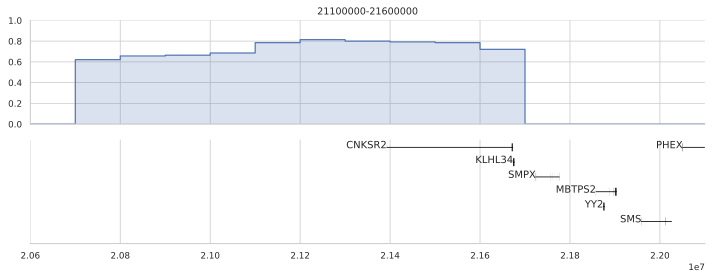

In [52]:
plot_next(1)

In [53]:
geneinfo('CNKSR2')
geneinfo('SMPX')
geneinfo('KLHL3')

**Symbol:** **_CNKSR2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CNK2, KSR2, MAGUIN, MRXSHG  
*connector enhancer of kinase suppressor of Ras 2*  
**Summary:** This gene encodes a multidomain protein that functions as a scaffold protein to mediate the mitogen-activated protein kinase pathways downstream from Ras. This gene product is induced by vitamin D and inhibits apoptosis in certain cancer cells. It may also play a role in ternary complex assembly of synaptic proteins at the postsynaptic membrane and coupling of signal transduction to membrane/cytoskeletal remodeling. Multiple transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Dec 2009].  
**Genomic position:** X:21372801-21654695 (hg38), X:21392536-21672813 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CNKSR2)  


 ----

**Symbol:** **_SMPX_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** Chisel, Csl, DFN6, DFNX4  
*small muscle protein X-linked*  
**Summary:** This gene encodes a small protein that has no known functional domains. Mutations in this gene are a cause of X-linked deafness-4, and the encoded protein may play a role in the maintenance of inner ear cells subjected to mechanical stress. Alternatively spliced transcript variants have been observed for this gene. [provided by RefSeq, Dec 2011].  
**Genomic position:** X:21705978-21758116 (hg38), X:21724090-21776281 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SMPX)  


 ----

**Symbol:** **_KLHL3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** PHA2D  
*kelch like family member 3*  
**Summary:** This gene is ubiquitously expressed and encodes a full-length protein which has an N-terminal BTB domain followed by a BACK domain and six kelch-like repeats in the C-terminus. These kelch-like repeats promote substrate ubiquitination of bound proteins via interaction of the BTB domain with the CUL3 (cullin 3) component of a cullin-RING E3 ubiquitin ligase (CRL) complex. Muatations in this gene cause pseudohypoaldosteronism type IID (PHA2D); a rare Mendelian syndrome featuring hypertension, hyperkalaemia and metabolic acidosis. Alternative splicing results in multiple transcript variants encoding distinct isoforms. [provided by RefSeq, Mar 2012].  
**Genomic position:** 5:137617500-137736089 (hg38), 5:136953189-137071779 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=KLHL3)  


 ----

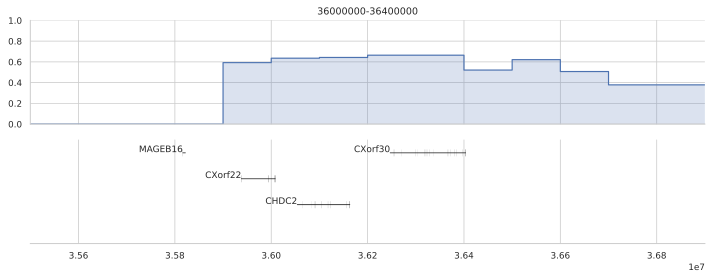

In [54]:
plot_next(2)

In [55]:
geneinfo('CFAP47')

**Symbol:** **_CFAP47_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CHDC2, CXorf22, CXorf30, CXorf59, SPGF52, SPGFX3  
*cilia and flagella associated protein 47*  
**Summary:** While this gene is well-supported by transcript data, no functional information on its protein product is currently available. [provided by RefSeq, Dec 2009].  
**Genomic position:** X:35919734-36385317 (hg38), X:36053908-36163187 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CFAP47)  


 ----

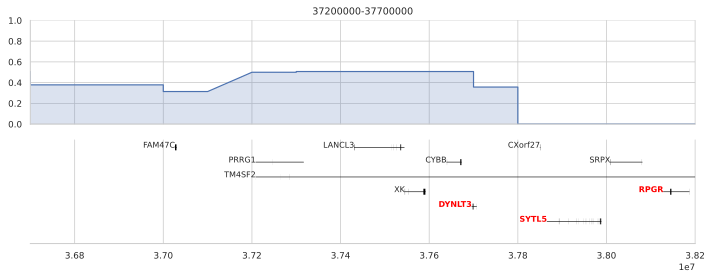

In [56]:
plot_next(3)

In [57]:
geneinfo('DYNLT3')
geneinfo('XK')
#geneinfo('PRRG1')
geneinfo('LANCL3')

**Symbol:** **_DYNLT3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** RP3, TCTE1L, TCTEX1L  
*dynein light chain Tctex-type 3*  
**Summary:** This gene encodes a member of a subclass of dynein light chains. The encoded protein homodimerizes and forms the light chain component of the cytoplasmic dynein motor protein complex. This protein may be important for binding dynein to specific cargos including the spindle checkpoint protein BUB3. This protein may also function independently of dynein as a transcriptional modulator. Pseudogenes of this gene are found on chromosomes 2 and 20.[provided by RefSeq, Mar 2010].  
**Genomic position:** X:37836757-37847571 (hg38), X:37696010-37706890 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DYNLT3)  


 ----

**Symbol:** **_XK_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** KX, NA, NAC, X1k, XKR1  
*X-linked Kx blood group*  
**Summary:** This locus controls the synthesis of the Kell blood group 'precursor substance' (Kx). Mutations in this gene have been associated with McLeod syndrome, an X-linked, recessive disorder characterized by abnormalities in the neuromuscular and hematopoietic systems. The encoded protein has structural characteristics of prokaryotic and eukaryotic membrane transport proteins. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:37685791-37732130 (hg38), HG1424_PATCH:37545821-37592192, X:37545012-37591383 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=XK)  


 ----

**Symbol:** **_LANCL3_** (protein-coding)  
*LanC like 3*  
**Genomic position:** X:37571569-37684463 (hg38), HG1424_PATCH:37431631-37544525, X:37430822-37543716 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=LANCL3)  


 ----

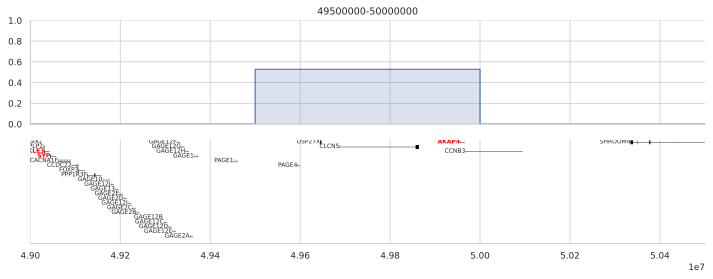

In [58]:
plot_next(4)

In [59]:
geneinfo('AKAP4')
geneinfo('CLCN5')
geneinfo('PAGE4')
geneinfo('USP27X')

**Symbol:** **_AKAP4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** AKAP 82, AKAP-4, AKAP82, CT99, FSC1, HI, PRKA4, hAKAP82, p82  
*A-kinase anchoring protein 4*  
**Summary:** The A-kinase anchor proteins (AKAPs) are a group of structurally diverse proteins, which have the common function of binding to the regulatory subunit of protein kinase A (PKA) and confining the holoenzyme to discrete locations within the cell. This gene encodes a member of the AKAP family. The encoded protein is localized to the sperm flagellum and may be involved in the regulation of sperm motility. Alternative splicing of this gene results in two transcript variants encoding different isoforms. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:50190777-50201007 (hg38), HG1436_HG1432_PATCH:50000162-50010412, X:49955406-49965664 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=AKAP4)  


 ----

**Symbol:** **_CLCN5_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CLC5, CLCK2, ClC-5, DENT1, DENTS, NPHL1, NPHL2, XLRH, XRN, hCIC-K2  
*chloride voltage-gated channel 5*  
**Summary:** This gene encodes a member of the ClC family of chloride ion channels and ion transporters. The encoded protein is primarily localized to endosomal membranes and may function to facilitate albumin uptake by the renal proximal tubule. Mutations in this gene have been found in Dent disease and renal tubular disorders complicated by nephrolithiasis. Alternatively spliced transcript variants have been found for this gene. [provided by RefSeq, Jan 2013].  
**Genomic position:** X:49922596-50099235 (hg38), HG1436_HG1432_PATCH:49732014-49908634, X:49687225-49863892 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CLCN5)  


 ----

**Symbol:** **_PAGE4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CT16.7, GAGE-9, GAGEC1, JM-27, JM27, PAGE-1, PAGE-4  
*PAGE family member 4*  
**Summary:** This gene is a member of the GAGE family. The GAGE genes are expressed in a variety of tumors and in some fetal and reproductive tissues. This gene is strongly expressed in prostate and prostate cancer. It is also expressed in other male and female reproductive tissues including testis, fallopian tube, uterus, and placenta, as well as in testicular cancer and uterine cancer. The protein encoded by this gene shares sequence similarity with other GAGE/PAGE proteins, and also belongs to a family of CT (cancer-testis) antigens. The protein may play a role in benign and malignant prostate diseases. A related pseudogene is located on chromosome 7. Alternate splicing results in multiple transcript variants. [provided by RefSeq, Jan 2016].  
**Genomic position:** X:49829260-49834264 (hg38), HG1436_HG1432_PATCH:49638659-49643372, X:49593863-49598576 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PAGE4)  


 ----

**Symbol:** **_USP27X_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** MRX105, USP22L, USP27, XLID105  
*ubiquitin specific peptidase 27 X-linked*  
**Summary:** This gene encodes a member of the peptidase protein family. The encoded protein functions as a deubiquitinase that is involved in upregulation of the pro-apoptotic Bim protein. This protein may act as a tumor suppressor by increasing levels of Bim to counteract anti-apoptotic signals in cancer cells. Mutations in this gene have been associated with X-linked cognitive disability. [provided by RefSeq, Dec 2016].  
**Genomic position:** X:49879484-49882558 (hg38), X:49644470-49647166 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=USP27X)  


 ----

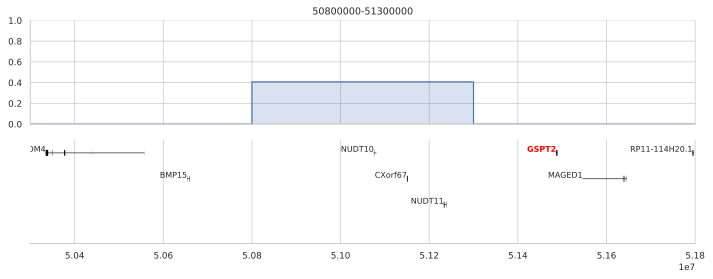

In [60]:
plot_next(5)

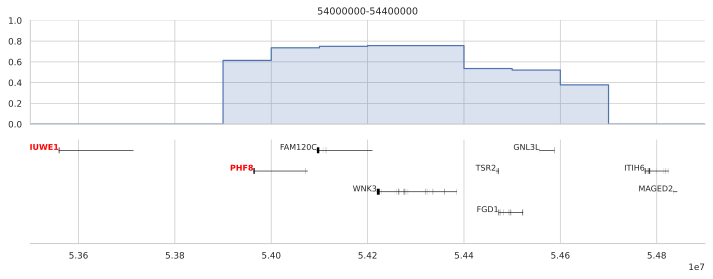

In [61]:
plot_next(6)

In [62]:
geneinfo('PHF8')
geneinfo('WNK3')

**Symbol:** **_PHF8_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** JHDM1F, KDM7B, MRXSSD, ZNF422  
*PHD finger protein 8*  
**Summary:** The protein encoded by this gene is a histone lysine demethylase that preferentially acts on histones in the monomethyl or dimethyl states. The encoded protein requires Fe(2+) ion, 2-oxoglutarate, and oxygen for its catalytic activity. The protein has an N-terminal PHD finger and a central Jumonji C domain. This gene is thought to function as a transcription activator. Defects in this gene are a cause of syndromic X-linked Siderius type intellectual disability (MRXSSD) and over-expression of this gene is associated with several forms of cancer. Multiple transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Jul 2017].  
**Genomic position:** X:53936676-54048958 (hg38), HG1433_PATCH:53679676-53791958, X:53963109-54075391 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PHF8)  


 ----

**Symbol:** **_WNK3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** PRKWNK3  
*WNK lysine deficient protein kinase 3*  
**Summary:** This gene encodes a protein belonging to the 'with no lysine' family of serine-threonine protein kinases. These family members lack the catalytic lysine in subdomain II, and instead have a conserved lysine in subdomain I. This family member functions as a positive regulator of the transcellular Ca2+ transport pathway, and it plays a role in the increase of cell survival in a caspase-3-dependent pathway. Alternative splicing results in multiple transcript variants. [provided by RefSeq, May 2010].  
**Genomic position:** X:54192823-54358642 (hg38), HG1433_PATCH:53935823-54101642, X:54219256-54385075 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=WNK3)  


 ----

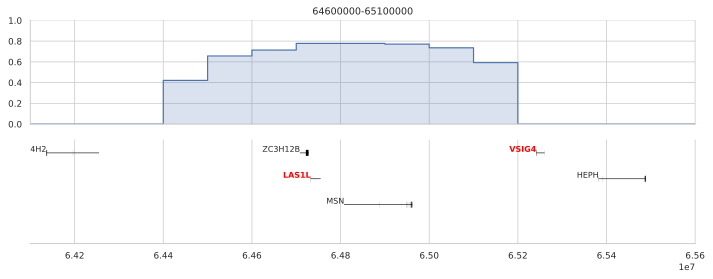

In [63]:
plot_next(7)

In [64]:
[geneinfo(x) for x in ['FRMD8P1', 'ZC3H12B', 'LAS1L', 'MSN']] ;

**Symbol:** **_FRMD8P1_**   
*FERM domain containing 8 pseudogene 1*  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=FRMD8P1)  


 ----

**Symbol:** **_ZC3H12B_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CXorf32, MCPIP2  
*zinc finger CCCH-type containing 12B*  
**Summary:** The protein encoded by this gene belongs to a family of CCCH-type zinc finger proteins that are involved in the proinflammatory activation of macrophages. The exact function of this family member is unknown, but it is thought to function as a ribonuclease. [provided by RefSeq, May 2010].  
**Genomic position:** X:65366638-65507887 (hg38), X:64708615-64727767 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ZC3H12B)  


 ----

**Symbol:** **_LAS1L_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** Las1, Las1-like, MRXSWTS, WTS, dJ475B7.2  
*LAS1 like ribosome biogenesis factor*  
**Genomic position:** X:65438549-65534810 (hg38), X:64732462-64754655 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=LAS1L)  


 ----

**Symbol:** **_MSN_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** HEL70, IMD50  
*moesin*  
**Summary:** Moesin (for membrane-organizing extension spike protein) is a member of the ERM family which includes ezrin and radixin. ERM proteins appear to function as cross-linkers between plasma membranes and actin-based cytoskeletons. Moesin is localized to filopodia and other membranous protrusions that are important for cell-cell recognition and signaling and for cell movement. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:65588377-65741931 (hg38), X:64808257-64961791 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MSN)  


 ----

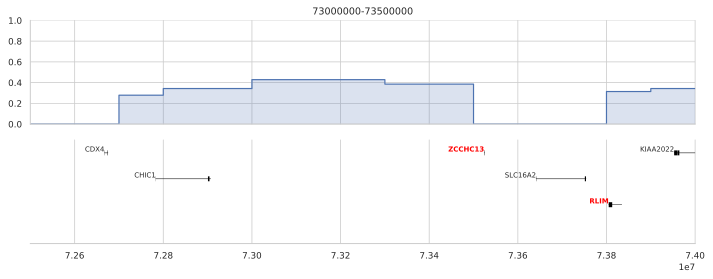

In [65]:
plot_next(8)

In [66]:
[geneinfo(x) for x in ['CHIC1', 'XIST']] ;

**Symbol:** **_CHIC1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** BRX  
*cysteine rich hydrophobic domain 1*  
**Summary:** This gene encodes a cysteine-rich hydrophobic (CHIC) domain-containing protein, and is one of the few protein-coding genes found near the X-inactivation center. Studies in mouse indicate that the mouse ortholog of this gene is subject to X-inactivation in mouse. Experiments with other CHIC domain-containing family members show that the cysteine residues are palmitoylated post-translationally, resulting in membrane association. Alternative splicing results in multiple transcript variants encoding different isoforms. [provided by RefSeq, May 2017].  
**Genomic position:** X:73563197-73687111 (hg38), X:72783036-72906937 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CHIC1)  


 ----

**Symbol:** **_XIST_** (ncRNA) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** DXS1089, DXS399E, LINC00001, NCRNA00001, SXI1, swd66  
*X inactive specific transcript*  
**Summary:** X inactivation is an early developmental process in mammalian females that transcriptionally silences one of the pair of X chromosomes, thus providing dosage equivalence between males and females. The process is regulated by several factors, including a region of chromosome X called the X inactivation center (XIC). The XIC comprises several non-coding and protein-coding genes, and this gene was the first non-coding gene identified within the XIC. This gene is expressed exclusively from the XIC of the inactive X chromosome, and is essential for the initiation and spread of X-inactivation. The transcript is a spliced RNA. Alternatively spliced transcript variants have been identified, but their full length sequences have not been determined. Mutations in the XIST promoter cause familial skewed X inactivation. [provided by RefSeq, Apr 2012].  
**Genomic position:** X:73820649-73852723 (hg38), X:73040486-73072588 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=XIST)  


 ----

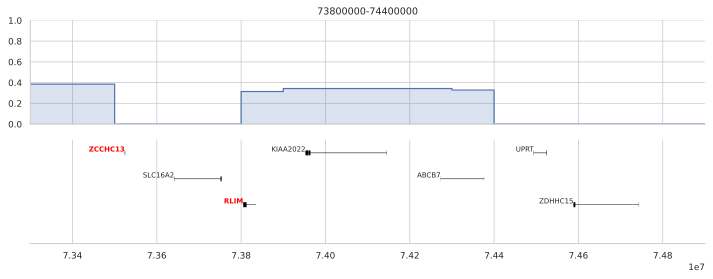

In [67]:
plot_next(9)

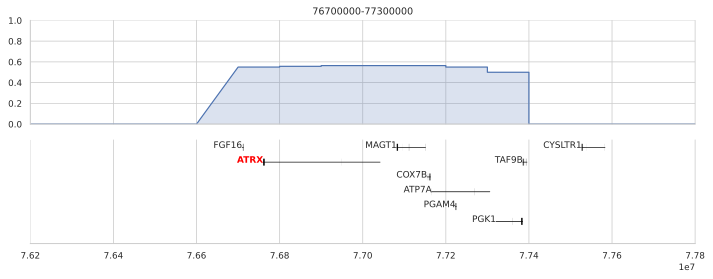

In [68]:
plot_next(10)

In [69]:
[geneinfo(x) for x in ['ATRX', 'MAGT1', 'COX7B', 'ATP7A', 'PGAM4']] ;

**Symbol:** **_ATRX_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** JMS, MRX52, RAD54, RAD54L, XH2, XNP, ZNF-HX  
*ATRX chromatin remodeler*  
**Summary:** The protein encoded by this gene contains an ATPase/helicase domain, and thus it belongs to the SWI/SNF family of chromatin remodeling proteins. This protein is found to undergo cell cycle-dependent phosphorylation, which regulates its nuclear matrix and chromatin association, and suggests its involvement in the gene regulation at interphase and chromosomal segregation in mitosis. Mutations in this gene are associated with X-linked syndromes exhibiting cognitive disabilities as well as alpha-thalassemia (ATRX) syndrome. These mutations have been shown to cause diverse changes in the pattern of DNA methylation, which may provide a link between chromatin remodeling, DNA methylation, and gene expression in developmental processes. Multiple alternatively spliced transcript variants encoding distinct isoforms have been reported. [provided by RefSeq, Jul 2017].  
**Genomic position:** X:77504880-77786233 (hg38), HG1426_PATCH:76765832-77047170, X:76760356-77041702 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ATRX)  


 ----

**Symbol:** **_MAGT1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CDG1CC, IAP, MRX95, OST3B, PRO0756, SLC58A1, XMEN, bA217H1.1  
*magnesium transporter 1*  
**Summary:** This gene encodes a ubiquitously expressed magnesium cation transporter protein that localizes to the cell membrane. This protein also associates with N-oligosaccharyl transferase and therefore may have a role in N-glycosylation. Mutations in this gene cause a form of X-linked intellectual disability (XLID). This gene may have multiple in-frame translation initiation sites, one of which would encode a shorter protein with an N-terminus containing a signal peptide at amino acids 1-29. [provided by RefSeq, Jul 2017].  
**Genomic position:** X:77825747-77899271 (hg38), HG1426_PATCH:77087318-77156547, X:77081861-77151090 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MAGT1)  


 ----

**Symbol:** **_COX7B_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** APLCC, LSDMCA2  
*cytochrome c oxidase subunit 7B*  
**Summary:** Cytochrome c oxidase (COX), the terminal component of the mitochondrial respiratory chain, catalyzes the electron transfer from reduced cytochrome c to oxygen. This component is a heteromeric complex consisting of 3 catalytic subunits encoded by mitochondrial genes and multiple structural subunits encoded by nuclear genes. The mitochondrially-encoded subunits function in electron transfer, and the nuclear-encoded subunits may function in the regulation and assembly of the complex. This nuclear gene encodes subunit VIIb, which is highly similar to bovine COX VIIb protein and is found in all tissues. This gene may have several pseudogenes on chromosomes 1, 2, 20 and 22. [provided by RefSeq, Jun 2011].  
**Genomic position:** X:77899440-77907376 (hg38), HG1426_PATCH:77160392-77168327, X:77154935-77162870 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=COX7B)  


 ----

**Symbol:** **_ATP7A_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** DSMAX, MK, MNK, SMAX3  
*ATPase copper transporting alpha*  
**Summary:** This gene encodes a transmembrane protein that functions in copper transport across membranes. This protein is localized to the trans Golgi network, where it is predicted to supply copper to copper-dependent enzymes in the secretory pathway. It relocalizes to the plasma membrane under conditions of elevated extracellular copper, and functions in the efflux of copper from cells. Mutations in this gene are associated with Menkes disease, X-linked distal spinal muscular atrophy, and occipital horn syndrome. Alternatively-spliced transcript variants have been observed. [provided by RefSeq, Aug 2013].  
**Genomic position:** X:77910690-78050395 (hg38), HG1426_PATCH:77171651-77311349, X:77166194-77305892 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ATP7A)  


 ----

**Symbol:** **_PGAM4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** PGAM-B, PGAM1, PGAM3, dJ1000K24.1  
*phosphoglycerate mutase family member 4*  
**Summary:** This intronless gene appears to have arisen from a retrotransposition event, yet it is thought to be an expressed, protein-coding gene. The encoded protein is a member of the phosphoglycerate mutase family, a set of enzymes that catalyze the transfer of a phosphate group from 3-phosphoglycerate to 2-phosphoglycerate. [provided by RefSeq, May 2010].  
**Genomic position:** X:77967949-77969638 (hg38), HG1426_PATCH:77228915-77230592, X:77223458-77225135 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PGAM4)  


 ----

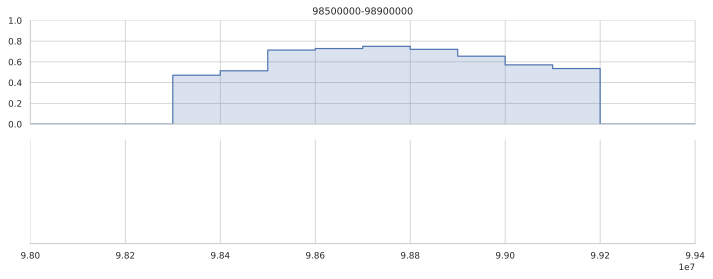

In [70]:
plot_next(11)

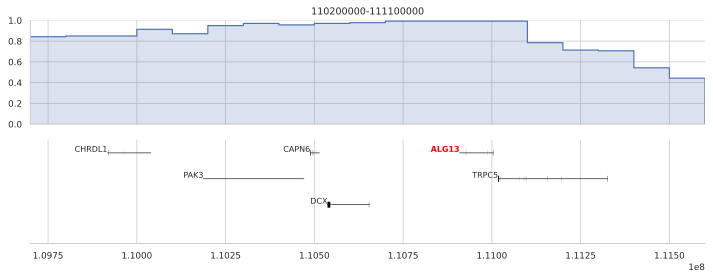

In [71]:
plot_next(12)

In [72]:
[geneinfo(x) for x in ['PAK3', 'CAPN6', 'DCX', 'SERTM2', 'ALG13', 'TRPC5', 'TRPC5OS']] ;

**Symbol:** **_PAK3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** ARA, MRX30, MRX47, OPHN3, PAK-3, PAK3beta, XLID30, bPAK, beta-PAK  
*p21 (RAC1) activated kinase 3*  
**Summary:** The protein encoded by this gene is a serine-threonine kinase and forms an activated complex with GTP-bound RAS-like (P21), CDC2 and RAC1. This protein may be necessary for dendritic development and for the rapid cytoskeletal reorganization in dendritic spines associated with synaptic plasticity. Defects in this gene are the cause of a non-syndromic form of X-linked intellectual disability. Alternatively spliced transcript variants encoding different isoforms have been identified. [provided by RefSeq, Jul 2017].  
**Genomic position:** X:110944285-111227361 (hg38), X:110187513-110470589 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PAK3)  


 ----

**Symbol:** **_CAPN6_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CANPX, CAPNX, CalpM, DJ914P14.1  
*calpain 6*  
**Summary:** Calpains are ubiquitous, well-conserved family of calcium-dependent, cysteine proteases. The calpain proteins are heterodimers consisting of an invariant small subunit and variable large subunits. The large subunit possesses a cysteine protease domain, and both subunits possess calcium-binding domains. Calpains have been implicated in neurodegenerative processes, as their activation can be triggered by calcium influx and oxidative stress. The protein encoded by this gene is highly expressed in the placenta. Its C-terminal region lacks any homology to the calmodulin-like domain of other calpains. The protein lacks critical active site residues and thus is suggested to be proteolytically inactive. The protein may play a role in tumor formation by inhibiting apoptosis and promoting angiogenesis. [provided by RefSeq, Nov 2009].  
**Genomic position:** X:111245099-111270483 (hg38), X:110488331-110513751 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CAPN6)  


 ----

**Symbol:** **_DCX_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** DBCN, DC, LISX, SCLH, XLIS  
*doublecortin*  
**Summary:** This gene encodes a member of the doublecortin family. The protein encoded by this gene is a cytoplasmic protein and contains two doublecortin domains, which bind microtubules. In the developing cortex, cortical neurons must migrate over long distances to reach the site of their final differentiation. The encoded protein appears to direct neuronal migration by regulating the organization and stability of microtubules. In addition, the encoded protein interacts with LIS1, the regulatory gamma subunit of platelet activating factor acetylhydrolase, and this interaction is important to proper microtubule function in the developing cortex. Mutations in this gene cause abnormal migration of neurons during development and disrupt the layering of the cortex, leading to epilepsy, cognitive disability, subcortical band heterotopia ('double cortex' syndrome) in females and lissencephaly ('smooth brain' syndrome) in males. Multiple transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Sep 2010].  
**Genomic position:** X:111293779-111412429 (hg38), X:110537007-110655603 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DCX)  


 ----

**Symbol:** **_SERTM2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** DKFZp686D0853, LINC00890  
*serine rich and transmembrane domain containing 2*  
**Genomic position:** X:111511645-111522399 (hg38), X:110754890-110765627 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SERTM2)  


 ----

**Symbol:** **_ALG13_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CDG1S, CXorf45, DEE36, EIEE36, GLT28D1, MDS031, TDRD13, YGL047W  
*ALG13 UDP-N-acetylglucosaminyltransferase subunit*  
**Summary:** The protein encoded by this gene is a subunit of a bipartite UDP-N-acetylglucosamine transferase. It heterodimerizes with asparagine-linked glycosylation 14 homolog to form a functional UDP-GlcNAc glycosyltransferase that catalyzes the second sugar addition of the highly conserved oligosaccharide precursor in endoplasmic reticulum N-linked glycosylation. Multiple transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Dec 2009].  
**Genomic position:** X:111665811-111760649 (hg38), X:110909043-111003877 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ALG13)  


 ----

**Symbol:** **_TRPC5_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** PPP1R159, TRP5  
*transient receptor potential cation channel subfamily C member 5*  
**Summary:** This gene belongs to the transient receptor family. It encodes one of the seven mammalian TRPC (transient receptor potential channel) proteins. The encoded protein is a multi-pass membrane protein and is thought to form a receptor-activated non-selective calcium permeant cation channel. The protein is active alone or as a heteromultimeric assembly with TRPC1, TRPC3, and TRPC4. It also interacts with multiple proteins including calmodulin, CABP1, enkurin, Na(+)-H+ exchange regulatory factor (NHERF ), interferon-induced GTP-binding protein (MX1), ring finger protein 24 (RNF24), and SEC14 domain and spectrin repeat-containing protein 1 (SESTD1). [provided by RefSeq, May 2010].  
**Genomic position:** X:111768011-112082776 (hg38), X:111017543-111326004 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TRPC5)  


 ----

**Symbol:** **_TRPC5OS_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** TRPC5-AS1  
*TRPC5 opposite strand*  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TRPC5OS)  


 ----

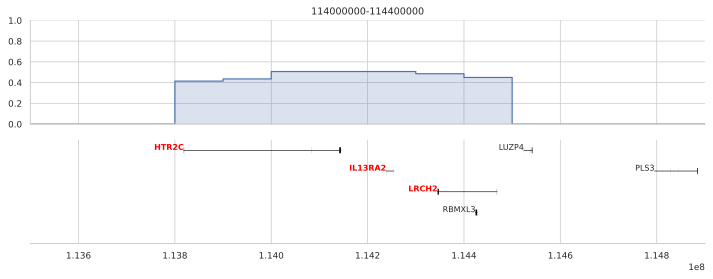

In [73]:
plot_next(13)

In [74]:
[geneinfo(x) for x in ['HTR2C', 'IL13RA2', 'LRCH2', 'RBMXL3']] ;

**Symbol:** **_HTR2C_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** 5-HT1C, 5-HT2C, 5-HTR2C, 5HTR2C, HTR1C  
*5-hydroxytryptamine receptor 2C*  
**Summary:** This gene encodes a seven-transmembrane G-protein-coupled receptor. The encoded protein responds to signaling through the neurotransmitter serotonin. The mRNA of this gene is subject to multiple RNA editing events, where adenosine residues encoded by the genome are converted to inosines. RNA editing is predicted to alter the structure of the second intracellular loop, thereby generating alternate protein forms with decreased ability to interact with G proteins. Abnormalities in RNA editing of this gene have been detected in victims of suicide that suffer from depression. In addition, naturally-occuring variation in the promoter and 5' non-coding and coding regions of this gene may show statistically-significant association with mental illness and behavioral disorders. Alternative splicing results in multiple different transcript variants. [provided by RefSeq, Jan 2015].  
**Genomic position:** X:114584078-114910061 (hg38), HG1462_PATCH:113820548-114146531, X:113818551-114144624 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=HTR2C)  


 ----

**Symbol:** **_IL13RA2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CD213A2, CT19, IL-13R, IL13BP  
*interleukin 13 receptor subunit alpha 2*  
**Summary:** The protein encoded by this gene is closely related to Il13RA1, a subuint of the interleukin 13 receptor complex. This protein binds IL13 with high affinity, but lacks cytoplasmic domain, and does not appear to function as a signal mediator. It is reported to play a role in the internalization of IL13. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:115003975-115019977 (hg38), HG1462_PATCH:114240445-114256447, X:114238538-114254540 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=IL13RA2)  


 ----

**Symbol:** **_LRCH2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** dA204F4.4  
*leucine rich repeats and calponin homology domain containing 2*  
**Summary:** This gene encodes a member of the leucine-rich repeat and calponin homology domain-containing protein family. These family members contain multiple N-terminal leucine-rich repeats, in addition to a C-terminal calponin homology domain, a type of domain that mediates interactions with actin filaments. These proteins are conserved across animal species, and studies of a similar Drosophila protein indicate a function as a cytoskeletal scaffolding protein. Alternative splicing of this gene results in multiple transcript variants. [provided by RefSeq, Sep 2011].  
**Genomic position:** X:115110616-115234096 (hg38), HG1462_PATCH:114347092-114470542, X:114345185-114468635 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=LRCH2)  


 ----

**Symbol:** **_RBMXL3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CXorf55  
*RBMX like 3*  
**Genomic position:** X:115189410-115192868 (hg38), HG1462_PATCH:114425870-114429338, X:114423963-114427431 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=RBMXL3)  


 ----

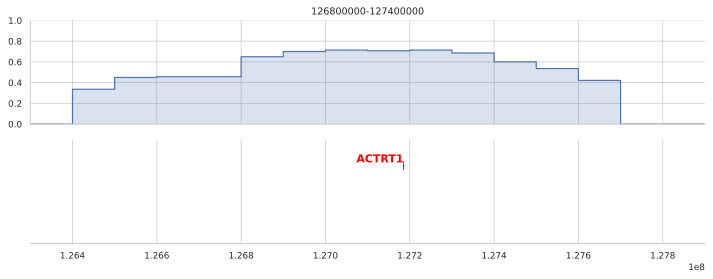

In [75]:
plot_next(14)

In [76]:
geneinfo('ACTRT1')

**Symbol:** **_ACTRT1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** AIP1, ARIP1, ARPT1, HSD27  
*actin related protein T1*  
**Summary:** This gene encodes a protein related to the cytoskeletal protein beta-actin. This protein is a major component of the calyx in the perinuclear theca of mammalian sperm heads, and it therefore likely functions in spermatid formation. This gene is intronless and is similar to a related gene located on chromosome 1. A related pseudogene has also been identified approximately 75 kb downstream of this gene on chromosome X. [provided by RefSeq, May 2010].  
**Genomic position:** X:128050962-128052403 (hg38), X:127184943-127186382 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ACTRT1)  


 ----

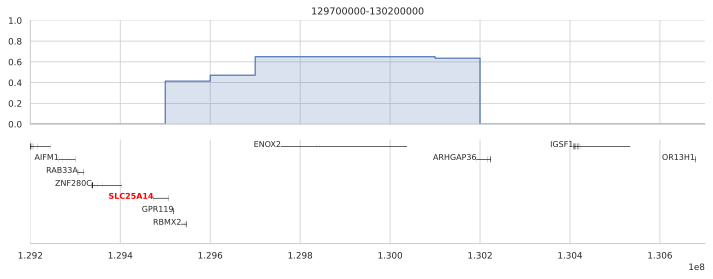

In [77]:
plot_next(15)

In [78]:
geneinfo('ENOX2')
geneinfo('ARHGAP36')

**Symbol:** **_ENOX2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** APK1, COVA1, tNOX  
*ecto-NOX disulfide-thiol exchanger 2*  
**Summary:** This gene is a tumor-specific member of the ECTO-NOX family of genes that encode cell surface NADH oxidases. The encoded protein has two enzymatic activities: catalysis of hydroquinone or NADH oxidation, and protein disulfide interchange. The protein also displays prion-like properties. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Aug 2013].  
**Genomic position:** X:130622325-130903234 (hg38), X:129757350-130037208 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENOX2)  


 ----

**Symbol:** **_ARHGAP36_** (protein-coding)  
*Rho GTPase activating protein 36*  
**Genomic position:** X:131058346-131089885 (hg38), X:130192216-130223857 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ARHGAP36)  


 ----

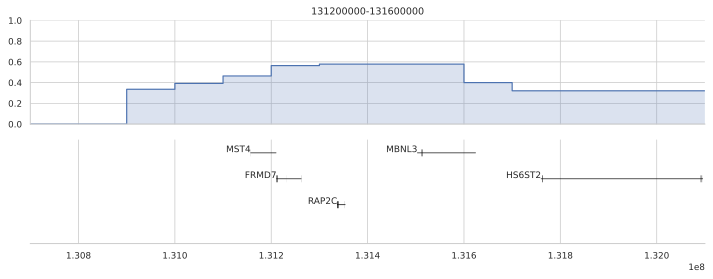

In [79]:
plot_next(16)

In [80]:
[geneinfo(x) for x in ['STK26', 'FRMD7', 'RAP2C', 'MBNL3']] ;

**Symbol:** **_STK26_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** MASK, MST4  
*serine/threonine kinase 26*  
**Summary:** The product of this gene is a member of the GCK group III family of kinases, which are a subset of the Ste20-like kinases. The encoded protein contains an amino-terminal kinase domain, and a carboxy-terminal regulatory domain that mediates homodimerization. The protein kinase localizes to the Golgi apparatus and is specifically activated by binding to the Golgi matrix protein GM130. It is also cleaved by caspase-3 in vitro, and may function in the apoptotic pathway. Several alternatively spliced transcript variants of this gene have been described, but the full-length nature of some of these variants has not been determined. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:132023302-132075943 (hg38), X:131157293-131209971 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=STK26)  


 ----

**Symbol:** **_FRMD7_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** NYS, NYS1, XIPAN  
*FERM domain containing 7*  
**Summary:** Mutations in this gene are associated with X-linked congenital nystagmus. [provided by RefSeq, Dec 2008].  
**Genomic position:** X:132076990-132128020 (hg38), X:131211021-131262048 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=FRMD7)  


 ----

**Symbol:** **_RAP2C_** (protein-coding)  
*RAP2C, member of RAS oncogene family*  
**Summary:** The protein encoded by this gene is a member of the Ras-related protein subfamily of the Ras GTPase superfamily. Members of this family are small GTPases that act as molecular switches to regulate cellular proliferation, differentiation, and apoptosis. This protein has been reported to activate in vitro transcriptional activity of the serum response element. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Sep 2012].  
**Genomic position:** X:132203024-132219480 (hg38), X:131337053-131353471 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=RAP2C)  


 ----

**Symbol:** **_MBNL3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CHCR, MBLX, MBLX39, MBXL  
*muscleblind like splicing regulator 3*  
**Summary:** This gene encodes a member of the muscleblind-like family of proteins. The encoded protein may function in regulation of alternative splicing and may play a role in the pathophysiology of myotonic dystrophy. Alternatively spliced transcript variants have been described. [provided by RefSeq, Dec 2009].  
**Genomic position:** X:132369317-132489968 (hg38), X:131503345-131623996 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MBNL3)  


 ----

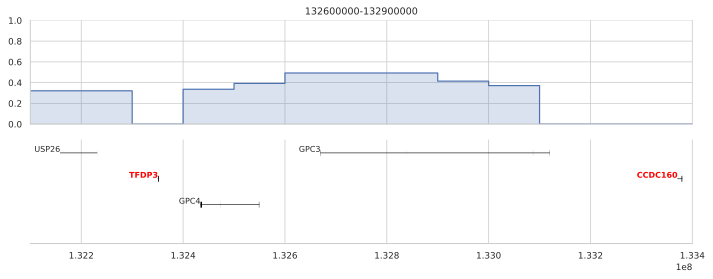

In [81]:
plot_next(17)

In [82]:
[geneinfo(x) for x in ['GPC3', 'GPC4']] ;

**Symbol:** **_GPC3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** DGSX, GTR2-2, MXR7, OCI-5, SDYS, SGB, SGBS, SGBS1  
*glypican 3*  
**Summary:** Cell surface heparan sulfate proteoglycans are composed of a membrane-associated protein core substituted with a variable number of heparan sulfate chains. Members of the glypican-related integral membrane proteoglycan family (GRIPS) contain a core protein anchored to the cytoplasmic membrane via a glycosyl phosphatidylinositol linkage. These proteins may play a role in the control of cell division and growth regulation. The protein encoded by this gene can bind to and inhibit the dipeptidyl peptidase activity of CD26, and it can induce apoptosis in certain cell types. Deletion mutations in this gene are associated with Simpson-Golabi-Behmel syndrome, also known as Simpson dysmorphia syndrome. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Sep 2009].  
**Genomic position:** X:133535745-133987100 (hg38), X:132669773-133119922 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=GPC3)  


 ----

**Symbol:** **_GPC4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** K-glypican, KPTS  
*glypican 4*  
**Summary:** Cell surface heparan sulfate proteoglycans are composed of a membrane-associated protein core substituted with a variable number of heparan sulfate chains. Members of the glypican-related integral membrane proteoglycan family (GRIPS) contain a core protein anchored to the cytoplasmic membrane via a glycosyl phosphatidylinositol linkage.  These proteins may play a role in the control of cell division and growth regulation.  The GPC4 gene is adjacent to the 3' end of GPC3 and may also play a role in Simpson-Golabi-Behmel syndrome. [provided by RefSeq, Jul 2008].  
**Genomic position:** X:133300103-133415489 (hg38), X:132434131-132549518 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=GPC4)  


 ----

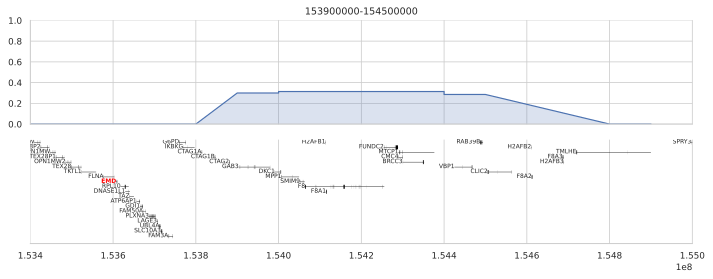

In [83]:
plot_next(18)